# Youtube Analysis Dashboard for Ads with AWS Quicksight

### Project intro:

In [4]:
# Built a YouTube data analyzing dashboard using AWS Quicksight that focusses on analysis of trending videos that 
#helps advertising the client choose their target audience for advertising campaigns.


### Data Description and Source

In [ ]:
# This dataset was taken from Kaggle readily scrapped using YouTube API. Various factors such as no. of views, shares,
# comments and likes to understand what videos are trending in various regions. Videos mostly comprise of trending
# videos from various regions. Every region data is further divided into two parts where the JSON file format data
#contains the category details pertaining to videos while the CSV file forma data comprises of videos and its statistics.
#This data would help the client understand the trending videos based on these factors and build and run their respective
#advertisement campaigns for their target audience.


### AWS CLI command to upload .json file (video category data file) from dektop to AWS S3 Bucket.

In [ ]:
# aws s3 cp . s3://suchi-de-on-youtube-raw-useast1-dev/youtube/raw_statistics_reference_data/ --recursive --exclude "*" --include "*.json"


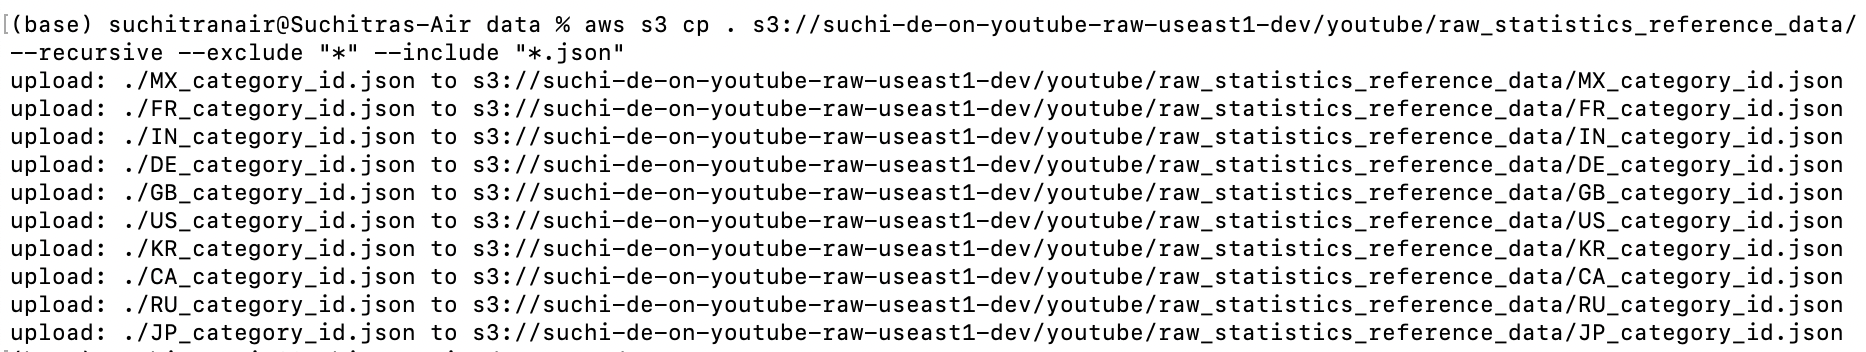

### AWS CLI command to upload csv file (youtube video data file) from dektop to AWS S3 Bucket. (As we need to analyze the data separately based on regions the data is divided based on various regions.)

In [ ]:
# aws s3 cp CAvideos.csv s3://suchi-de-on-youtube-raw-useast1-dev/youtube/raw_statistics/region=ca/
# aws s3 cp DEvideos.csv s3://suchi-de-on-youtube-raw-useast1-dev/youtube/raw_statistics/region=de/
# aws s3 cp FRvideos.csv s3://suchi-de-on-youtube-raw-useast1-dev/youtube/raw_statistics/region=fr/
# aws s3 cp GBvideos.csv s3://suchi-de-on-youtube-raw-useast1-dev/youtube/raw_statistics/region=gb/
# aws s3 cp INvideos.csv s3://suchi-de-on-youtube-raw-useast1-dev/youtube/raw_statistics/region=in/
# aws s3 cp JPvideos.csv s3://suchi-de-on-youtube-raw-useast1-dev/youtube/raw_statistics/region=jp/
# aws s3 cp KRvideos.csv s3://suchi-de-on-youtube-raw-useast1-dev/youtube/raw_statistics/region=kr/
# aws s3 cp MXvideos.csv s3://suchi-de-on-youtube-raw-useast1-dev/youtube/raw_statistics/region=mx/
# aws s3 cp RUvideos.csv s3://suchi-de-on-youtube-raw-useast1-dev/youtube/raw_statistics/region=ru/
# aws s3 cp USvideos.csv s3://suchi-de-on-youtube-raw-useast1-dev/youtube/raw_statistics/region=us/

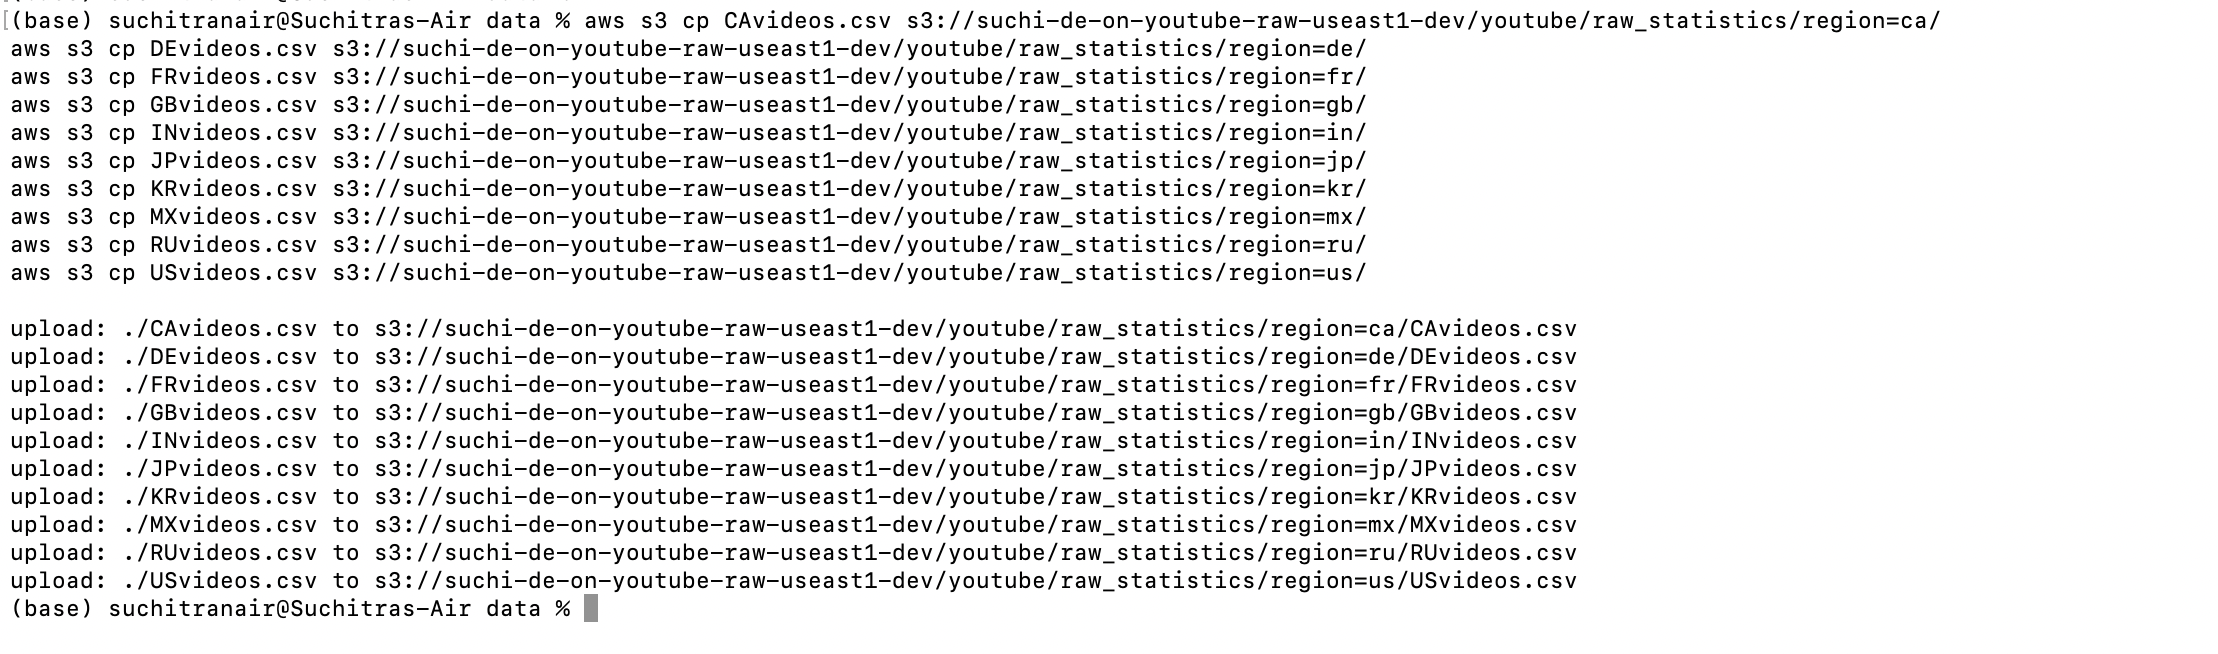

### Converted video category JSON file format to parquet version using the following python code on AWS Lambda.

In [ ]:
import awswrangler as wr
import pandas as pd 
import urllib.parse
import os

#Temporary hardcoded AWS Settings; i.e., to be set as OS variable in Lambda
os_input_s3_cleansed_layer= os.environ['s3_cleansed_layer']
os_input_glue_catalog_db_name = os.environ['glue_catalog_db_name']
os_input_glue_catalog_table_name = os.environ['glue_catalog_table_name']
os_input_write_data_operation = os.environ['write_data_operation']


def lambda_handler(event, context):
    #Get the object from the event and show its content type
    bucket = event['Records'][0]['s3']['bucket']['name']
    key = urllib.parse.unquote_plus(event['Records'][0]['s3']['object']['key'], encoding='utf-8')
    try:
        
        #Creating dataframe from content 
        df_raw = wr.s3.read_json('s3://{}/{}'.format(bucket, key))
        
        #Extracting required columns:
        df_step_1 = pd.json_normalize(df_raw['items'])
        
        #Write to S3
        wr_response = wr.s3.to_parquet(
            df = df_step_1,
            path = os_input_s3_cleansed_layer,
            dataset = True,
            database = os_input_glue_catalog_db_name,
            table = os_input_glue_catalog_table_name,
            mode = os_input_write_data_operation
        )
        
        return wr_response
    except Exception as e:
        print(e)
        print('Error getting object {} from bucket {}. Make sure they exist and your bucket is in the same region as this function.'.format(key,bucket))
        raise e
        

In [2]:
#Explanation of the above code:

#The purpose of the function is to read a JSON file from an S3 bucket, extract required columns, and then write the 
# data to a Parquet file in a different S3 bucket location. The script imports the awswrangler and pandas libraries 
# for data manipulation, urllib.parse to parse the S3 object key, and os to retrieve environment variables that have 
# been set as AWS Lambda function parameters. The function is defined with two parameters: event and context.event 
# is a JSON object that represents the input data to the function, and context is a dictionary that provides  
# information about the current execution environment. The lambda_handler function retrieves the bucket and key  
# values from the event object, reads the JSON content of the file from S3 using the awswrangler library, extracts  
# required columns using pd.json_normalize, and writes the data to a Parquet file in a different S3 location using 
# the wr.s3.to_parquet method. The function returns the response object wr_response, which contains information  
#about the write operation. If an error occurs, the function prints an error message and raises the error.


In [ ]:
# Created an S3 trigger that would run every time any manipulation such as update/add/deletion of .json files are 
# carried out in the respective S3 source bucket where the source data is stored. 
# This trigger would automatically take up the source data and convert into parquet version while storing the same
# in the target S3 bucket location.

### Converted video data in CSV file format to parquet version using the following spark-python code job on AWS Glue ETL.

In [ ]:
import sys
from awsglue.transforms import *
from awsglue.utils import getResolvedOptions
from pyspark.context import SparkContext
from awsglue.context import GlueContext
from awsglue.job import Job

from awsglue.dynamicframe import DynamicFrame

## @params: [JOB_NAME]
args = getResolvedOptions(sys.argv, ['JOB_NAME'])

sc = SparkContext()
glueContext = GlueContext(sc)
spark = glueContext.spark_session
job = Job(glueContext)
job.init(args['JOB_NAME'], args)
## @type: DataSource
## @args: [database = "suchi-de-on-youtube-raw-db1", table_name = "raw_statistics", transformation_ctx = "datasource0"]
## @return: datasource0
## @inputs: []

predicate_pushdown = "region in ('ca','gb','us', 'in')"

datasource0 = glueContext.create_dynamic_frame.from_catalog(database = "suchi-de-on-youtube-raw-db1", table_name = "raw_statistics", transformation_ctx = "datasource0", push_down_predicate = predicate_pushdown)
## @type: ApplyMapping
## @args: [mapping = [("video_id", "string", "video_id", "string"), ("trending_date", "string", "trending_date", "string"), ("title", "string", "title", "string"), ("channel_title", "string", "channel_title", "string"), ("category_id", "long", "category_id", "long"), ("publish_time", "string", "publish_time", "string"), ("tags", "string", "tags", "string"), ("views", "long", "views", "long"), ("likes", "long", "likes", "long"), ("dislikes", "long", "dislikes", "long"), ("comment_count", "long", "comment_count", "long"), ("thumbnail_link", "string", "thumbnail_link", "string"), ("comments_disabled", "boolean", "comments_disabled", "boolean"), ("ratings_disabled", "boolean", "ratings_disabled", "boolean"), ("video_error_or_removed", "boolean", "video_error_or_removed", "boolean"), ("description", "string", "description", "string"), ("region", "string", "region", "string")], transformation_ctx = "applymapping1"]
## @return: applymapping1
## @inputs: [frame = datasource0]
applymapping1 = ApplyMapping.apply(frame = datasource0, mappings = [("video_id", "string", "video_id", "string"), ("trending_date", "string", "trending_date", "string"), ("title", "string", "title", "string"), ("channel_title", "string", "channel_title", "string"), ("category_id", "long", "category_id", "long"), ("publish_time", "string", "publish_time", "string"), ("tags", "string", "tags", "string"), ("views", "long", "views", "long"), ("likes", "long", "likes", "long"), ("dislikes", "long", "dislikes", "long"), ("comment_count", "long", "comment_count", "long"), ("thumbnail_link", "string", "thumbnail_link", "string"), ("comments_disabled", "boolean", "comments_disabled", "boolean"), ("ratings_disabled", "boolean", "ratings_disabled", "boolean"), ("video_error_or_removed", "boolean", "video_error_or_removed", "boolean"), ("description", "string", "description", "string"), ("region", "string", "region", "string")], transformation_ctx = "applymapping1")
## @type: ResolveChoice
## @args: [choice = "make_struct", transformation_ctx = "resolvechoice2"]
## @return: resolvechoice2
## @inputs: [frame = applymapping1]
resolvechoice2 = ResolveChoice.apply(frame = applymapping1, choice = "make_struct", transformation_ctx = "resolvechoice2")
## @type: DropNullFields
## @args: [transformation_ctx = "dropnullfields3"]
## @return: dropnullfields3
## @inputs: [frame = resolvechoice2]
dropnullfields3 = DropNullFields.apply(frame = resolvechoice2, transformation_ctx = "dropnullfields3")
## @type: DataSink
## @args: [connection_type = "s3", connection_options = {"path": "s3://suchi-de-on-youtube-cleansed-useast1-dev/youtube/raw_statistics/"}, format = "parquet", transformation_ctx = "datasink4"]
## @return: datasink4
## @inputs: [frame = dropnullfields3]

datasink1 = dropnullfields3.toDF().coalesce(1)
df_final_output = DynamicFrame.fromDF(datasink1, glueContext, "df_final_output")


datasink4 = glueContext.write_dynamic_frame.from_options(frame = dropnullfields3, connection_type = "s3", connection_options = {"path": "s3://suchi-de-on-youtube-cleansed-useast1-dev/youtube/raw_statistics/", "partitionKeys":["region"]}, format = "parquet", transformation_ctx = "datasink4")
job.commit()



### ETL job to process the Athena query to parquet in Analytical S3 bucket.

In [ ]:
# Creating a final ETL pipeline, whose main job is to run Athena query from the cleaned tables and store the result in 
#parquet format in analytics bucket in S3, which further will be used in analytics.


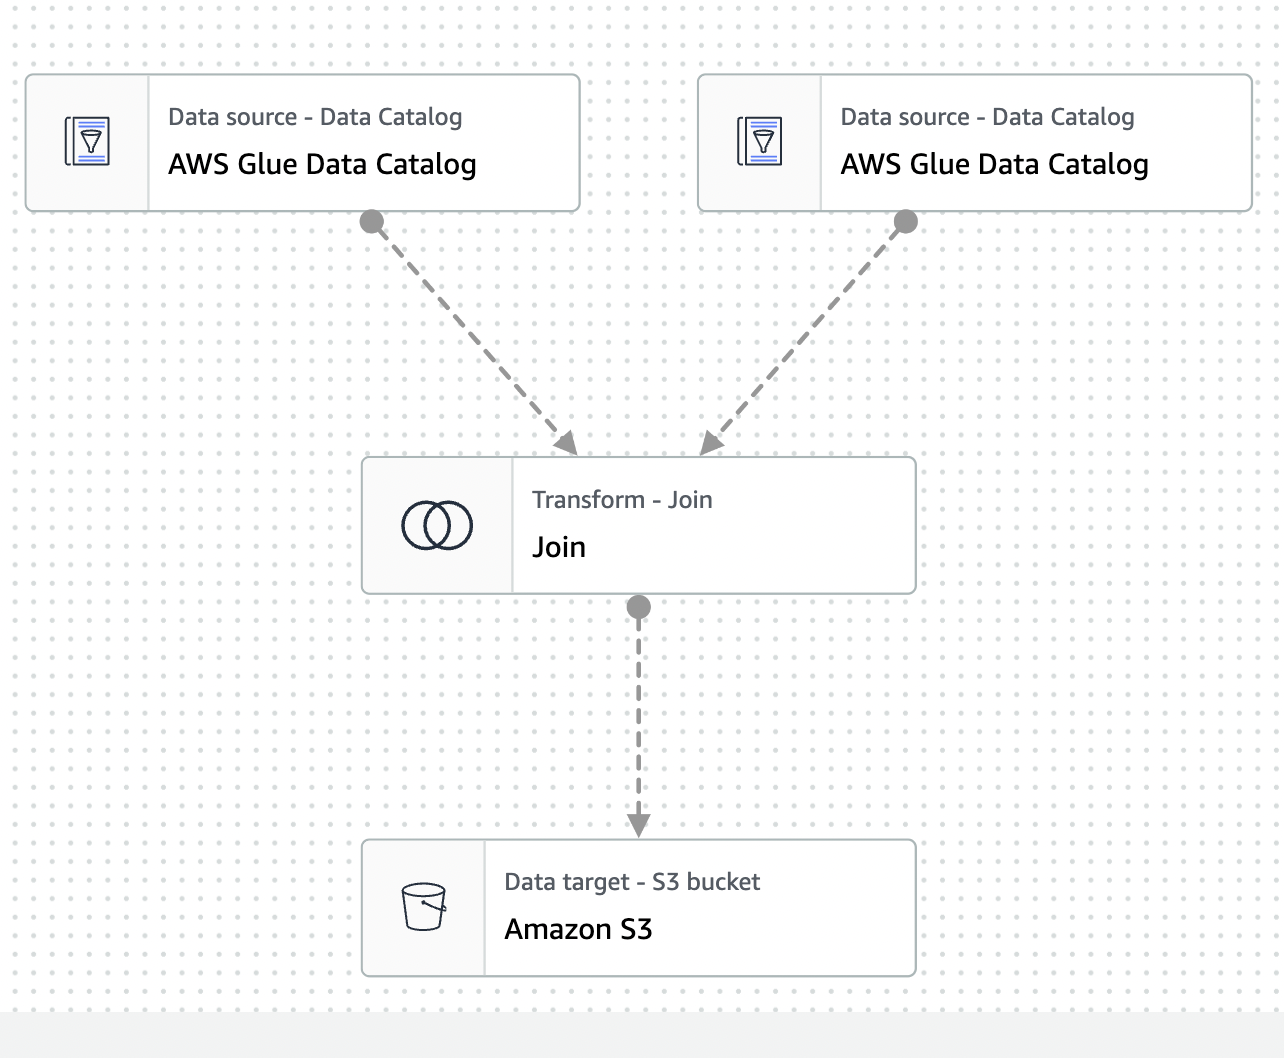